In [1]:
import warnings
warnings.simplefilter("ignore", UserWarning)

import os
import sys
import scanpy as sc
import anndata

import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

import itertools
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

import biolord

In [2]:
import pickle

In [3]:
with open("synthetic_data/no_dependencies_simple_synthetic_data.pkl", "rb") as f:
    adata1 = pickle.load(f)

In [4]:
biolord.Biolord.setup_anndata(
    adata=adata1,
)

In [5]:
import numpy as np
import pandas as pd


# Define probabilities for each set
train_prob = 0.8
val_prob = 0.10
test_prob = 0.10
choices = ['train', 'test', 'ood']
# Apply the assign_split function to each sample
probabilities = [train_prob, val_prob, test_prob]
adata1.obs['split_random'] = np.random.choice(choices, size=adata1.shape[0], p=probabilities)

# Verify the distribution of train_val_test
print("Distribution of split_random:")
print(adata1.obs['split_random'].value_counts())


Distribution of split_random:
split_random
train    1588
ood       207
test      205
Name: count, dtype: int64


In [6]:
module_params = {
    "decoder_width": 512,
    "decoder_depth": 6,
    "attribute_nn_width": 256,
    "attribute_nn_depth": 2,
    "unknown_attribute_noise_param": 1e0,
    "seed": 42,
    "n_latent_attribute_ordered": 5,
    "n_latent_attribute_categorical": 0,
    "gene_likelihood": "nb",
    "reconstruction_penalty": 1e1,
    "unknown_attribute_penalty": 1e0,
    "attribute_dropout_rate": 0.1
}

In [7]:
model = biolord.Biolord(
    adata=adata1,
    n_latent=5,
    model_name="atac_nb",
    module_params=module_params,
)

Seed set to 42


In [8]:
trainer_params = {
    "n_epochs_warmup": 0,
    "decoder_lr": 1e-4,
    "decoder_wd": 1e-4,
    "attribute_nn_lr": 1e-2,
    "attribute_nn_wd": 4e-8,
    "step_size_lr": 45,
    "cosine_scheduler": True,
    "scheduler_final_lr": 1e-5,
}

In [9]:
model.train(
    max_epochs=1000,
    batch_size=2000,
    plan_kwargs=trainer_params,
    early_stopping=False,
    enable_checkpointing=False,
    early_stopping_patience=20,
    check_val_every_n_epoch=10,
    num_workers=1,
)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 1000/1000: 100%|██████████| 1000/1000 [01:09<00:00, 15.12it/s, v_num=1, generative_mean_accuracy=0, generative_var_accuracy=0, biolord_metric=0, reconstruction_loss=1.55e+3, unknown_attribute_penalty_loss=10.2, val_generative_mean_accuracy=0.975, val_generative_var_accuracy=-0.0576, val_biolord_metric=0.459, val_LOSS_KEYS.RECONSTRUCTION=1.56e+3, val_LOSS_KEYS.UNKNOWN_ATTRIBUTE_PENALTY=4.22]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 1000/1000: 100%|██████████| 1000/1000 [01:09<00:00, 14.33it/s, v_num=1, generative_mean_accuracy=0, generative_var_accuracy=0, biolord_metric=0, reconstruction_loss=1.55e+3, unknown_attribute_penalty_loss=10.2, val_generative_mean_accuracy=0.975, val_generative_var_accuracy=-0.0576, val_biolord_metric=0.459, val_LOSS_KEYS.RECONSTRUCTION=1.56e+3, val_LOSS_KEYS.UNKNOWN_ATTRIBUTE_PENALTY=4.22]


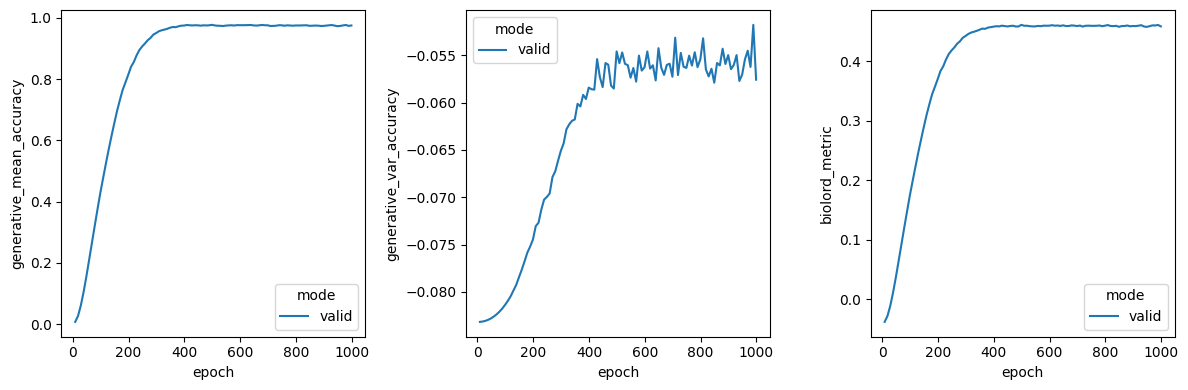

In [13]:
size = 4
vals = ["generative_mean_accuracy", "generative_var_accuracy", "biolord_metric"]
fig, axs = plt.subplots(nrows=1, ncols=len(vals), figsize=(size * len(vals), size))

model.epoch_history = pd.DataFrame().from_dict(model.training_plan.epoch_history)
for i, val in enumerate(vals):
    sns.lineplot(
        x="epoch",
        y=val,
        hue="mode",
        data=model.epoch_history[model.epoch_history["mode"] == "valid"],
        ax=axs[i],
    )

plt.tight_layout()
plt.show()

In [14]:
# Assuming `model` is an instance of Biolord and trained
latent_unknown_attributes_adata, latent_adata = model.get_latent_representation_adata(
    adata=adata1,  # Your AnnData object
    indices=[i for i in range(2000)],  # Use all cells by default
    batch_size=2000,  # Adjust batch size as needed
    nullify_attribute=None,  # Specify if any attribute should be nullified
)

# Access latent variables
latent_unknown_attributes = latent_unknown_attributes_adata.X
full_latent_representation = latent_adata.X


In [15]:
# Assuming `latent` is extracted as shown earlier
latent_adata.obsm["X_biolord_latent"] = latent_adata.X

In [16]:
import polyptich as pp
import matplotlib as mpl

(array([[ 0.,  4.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.],
        [ 3.,  4.,  3.,  4.,  5.,  3.,  5.,  3.,  0.,  4.],
        [ 8., 12., 14., 20., 10., 17., 17., 10., 14., 12.],
        [30., 41., 29., 28., 42., 38., 38., 36., 34., 32.],
        [53., 45., 71., 52., 55., 50., 46., 47., 47., 48.],
        [42., 43., 41., 61., 49., 46., 51., 50., 59., 58.],
        [33., 30., 28., 34., 23., 28., 33., 26., 32., 36.],
        [16., 11., 14., 14.,  9., 12., 11., 13., 12., 16.],
        [ 4.,  2.,  6.,  1.,  3.,  5.,  4.,  1.,  1.,  1.],
        [ 0.,  1.,  1.,  0.,  2.,  0.,  1.,  0.,  0.,  0.]]),
 array([-3.37630677, -2.69497304, -2.01363931, -1.33230557, -0.65097184,
         0.03036189,  0.71169562,  1.39302936,  2.07436309,  2.75569682,
         3.43703055]),
 array([9.60405596e-05, 1.00065551e-01, 2.00035062e-01, 3.00004572e-01,
        3.99974082e-01, 4.99943593e-01, 5.99913103e-01, 6.99882614e-01,
        7.99852124e-01, 8.99821635e-01, 9.99791145e-01]),
 <matplotlib.collections.Qu

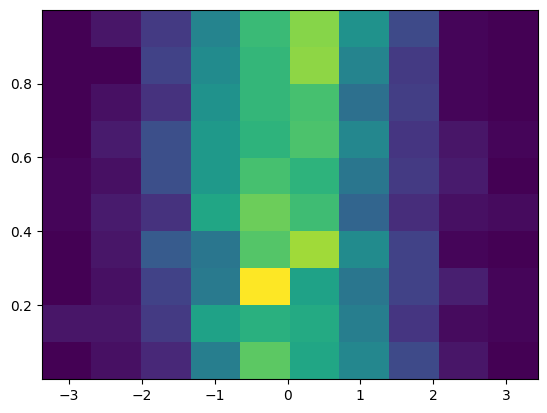

In [17]:
plt.hist2d(latent_adata.X[:,0],latent_adata.obs["Linear1"] )

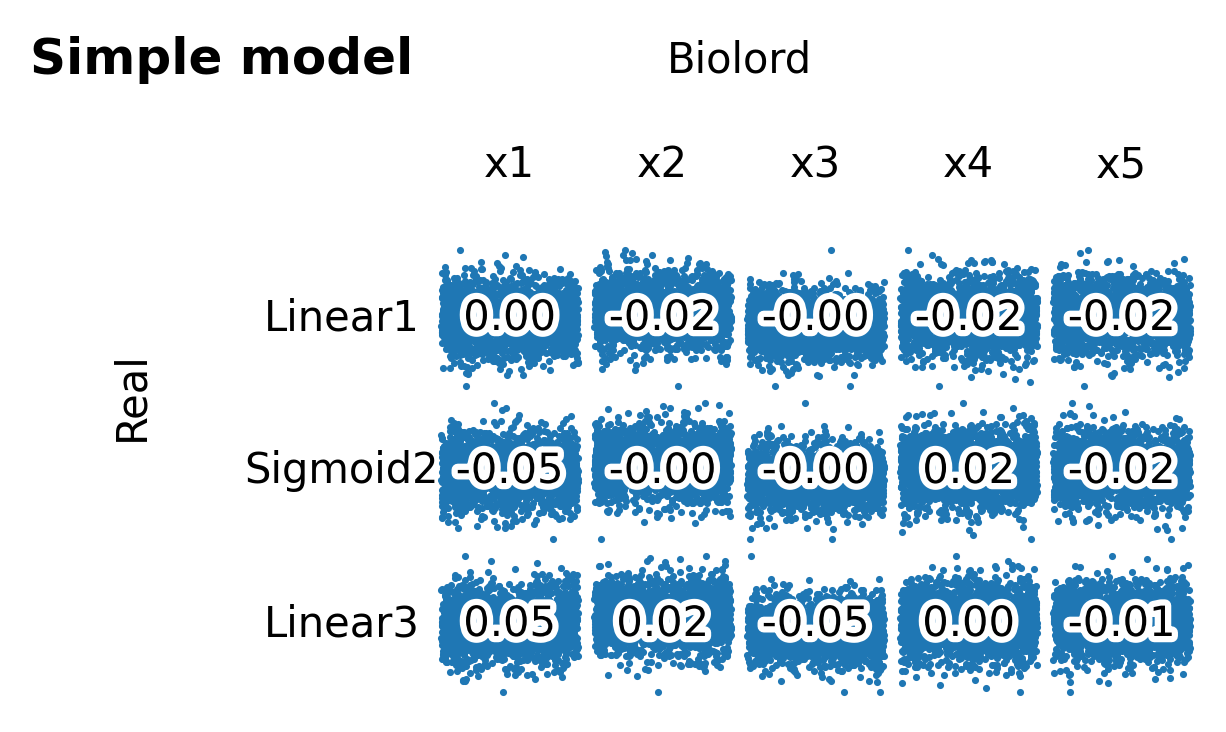

In [18]:
# Prepare the methods and names
methods = ["X_biolord_latent"]
names = ["Biolord"]

for index, method in enumerate(methods):
    fig = pp.grid.Figure(pp.grid.Grid(padding_height=0, padding_width=0))

    grid = fig.main[1, 1] = pp.grid.Grid(padding_height=0.01, padding_width=0.01)
    s = 0.5

    w = 0.5
    h = 0.5

    max_n = 1000

    rows = pd.DataFrame({
        "name": ["Linear1", "Sigmoid2", "Linear3"],
    })
    rows["ix"] = range(len(rows))
    rows = rows.set_index("name")

    columns = pd.DataFrame({
        "name": [f"IC{i+1}" for i in range(min(latent_adata.obsm[method].shape[1], 16))],
    })
    columns["ix"] = range(len(columns))
    columns = columns.set_index("name")

    for row_name, (i,) in rows.iterrows():
        panel, ax = grid[i + 1, 0] = pp.grid.Panel((w, h))
        ax.text(0.4, 0.5, row_name, ha="center", va="center")
        ax.axis("off")

    for i in columns["ix"]:
        panel, ax = grid[0, i + 1] = pp.grid.Panel((w, h))
        ax.text(0.5, 0.5, f"x{i+1}", ha="center", va="center")
        ax.axis("off")

    for row_name, (i,) in rows.iterrows():
        for column_name, (j,) in columns.iterrows():
            x = latent_adata.obs[row_name]
            y = latent_adata.obsm[method][:, j]
            panel, ax = grid[i + 1, j + 1] = pp.grid.Panel((w, h))
            ax.scatter(x, y, s=0.5)
            cor = np.corrcoef(x, y)[0, 1]
            text = ax.text(0.5, 0.5, f"{cor:.2f}", transform=ax.transAxes, ha="center", va="center")
            text.set_path_effects(
                [
                    mpl.patheffects.Stroke(linewidth=3, foreground="white"),
                    mpl.patheffects.Normal(),
                ]
            )
            ax.axis("off")
    fig.main.align()

    horizontal = fig.main[0, 1] = pp.grid.Panel((grid.width, 0.2))
    horizontal.axis("off")
    horizontal.text(0.5, 0.5, names[index], va="center", ha="center")

    vertical = fig.main[1, 0] = pp.grid.Panel((0.2, grid.height))
    vertical.axis("off")
    vertical.text(-0.5, 0.5, "Real", rotation=90, va="center", ha="center")

    # Add a top-left title
    top_left = fig.main[0, 0] = pp.grid.Panel((0.4, 0.2))  # Adjust width and height as needed
    top_left.axis("off")
    top_left.text(0.5, 0.5, "Simple model", va="center", ha="center", fontsize=12, fontweight="bold")
    fig.display()
